# Exploratory Data Analysis

Nesse notebook, é conduzida uma análise exploratória de dados a fim de analisar a distribuição individual das variáveis e suas interrelações a fim de extrair insights para a etapa de modelagem preditiva. 

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from statsmodels.distributions.empirical_distribution import ECDF  # função densidade acumulada empírica

In [2]:
%matplotlib inline

#plt.style.use('ggplot')
sns.set(font_scale=0.9)

In [3]:
# definindo paleta de cores para variável resposta 
# (para manter a consistência e facilitar a interpretação em diferentes gráficos)
cores = {
    'bom':'tab:blue',
    'ruim':'firebrick'
}

## importando dataset

In [4]:
datapath = Path('../data')

with open(f'{datapath}/data.pickle', 'rb') as file:
    data = pickle.load(file)

## Analisando variável resposta `cred_score`

Relembrando...

A variável `cred_score` foi remapeada da seguinte forma:

```bash
    0 = bom
    1 = ruim
```

In [5]:
data['cred_score'].value_counts()

0    700
1    300
Name: cred_score, dtype: int64

Nota-se um desbalanceamento da amostra, i.e., score de crédito ruim (1) são mais raros que scores bons (0), na proporção 30%/70%, respectivamente. 

<font color='red'>**OBS:**</font> esse fator deve ser considerado na análise preditiva. Se possível, ajustar tal desbalanceando atribuindo maior peso aos scores ruins (classe mais rara).

## descrevendo features numéricas

In [6]:
data.describe()

,duration,cred_amount,installment,resid_since,age,n_creds,n_liable_people
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


1. Nota-se que as variáveis numéricas apresentam unidades distintas. Isso não é um problema para *Decision Trees*, mas devem ser padronizadas antes de se estimar um modelo linear.

2. Há uma leve assimetria em suas distribuições (mediana != média) para a maioria delas. Esse fato será mais explorado graficamente.

3. A variável cred_amount pode apresentar *outlier* (máx. está muito acima do P75).

<br>

A distribuição individual dessas variáveis também é explorada visualmente a seguir:

In [16]:
num_vars = [f for f in data.columns if data[f].dtype == 'int' or data[f].dtype == 'float']

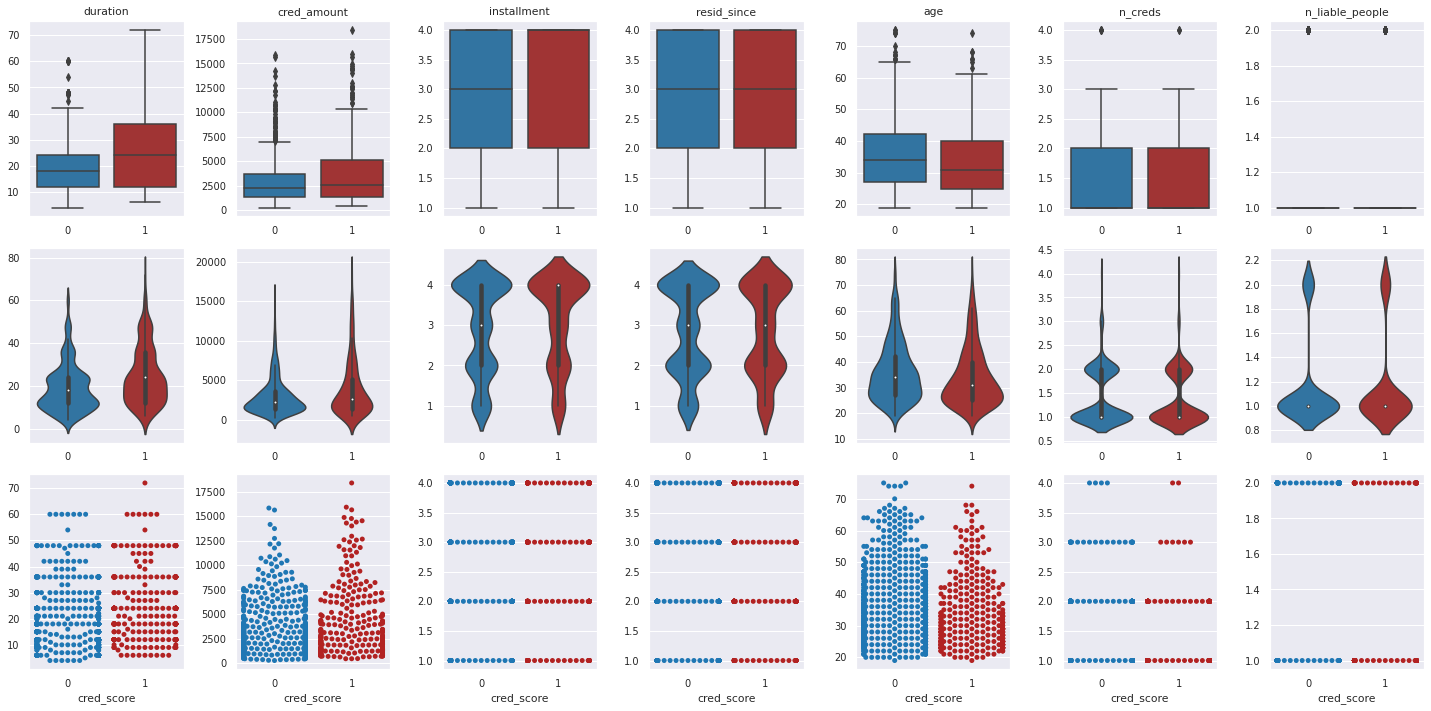

In [17]:
%%capture --no-display
# ocultando warnings do swarmplot (basicamente, os pontos não cabem todos no espaço designado)

fig, ax = plt.subplots(3, len(num_vars), figsize=(20,10))

# obs: swarmplot é pesado. Não é recomendado para grandes datasets
for i in range(len(num_vars)):
    sns.boxplot(y=num_vars[i], x='cred_score', data=data, palette=[cores['bom'], cores['ruim']], ax=ax[0,i])
    sns.violinplot(y=num_vars[i], x='cred_score', data=data, palette=[cores['bom'], cores['ruim']], ax=ax[1,i])
    sns.swarmplot(y=num_vars[i], x='cred_score', data=data, palette=[cores['bom'], cores['ruim']], ax=ax[2,i])
    
    # ajustando labels
    ax[0,i].set_ylabel('')
    ax[1,i].set_ylabel('')
    ax[2,i].set_ylabel('')
    ax[0,i].set_xlabel('')
    ax[1,i].set_xlabel('')
    ax[2,i].set_xlabel('cred_score')
    ax[0,i].set_title(num_vars[i])
    
plt.tight_layout()

Nos boxplots acima, notamos os seguintes padrões:

- **duration:** indivíduos com escore "ruim" estão mais dispersos entre diferentes durações de empréstimo. Além da maior dispersão, estes tendem a tomar empréstimos com prazos mais elevados, em média. 
- **cred_amount:** de maneira similar à duração do empréstimo, vemos que indivíduos com escore de crédito ruim tendem a tomar empréstimos de maior valor, em média. 
- **installment:** para esta variável, precisaremos investigar com um pouco mais de cautela. Não se pode inferir muita coisa a partir desse gráfico. 
- **resid_since:** o mesmo se pode dizer para essa variável. Não há diferença aparente entre os dois grupos.
- **age:** aparentemente, indivíduos com escore de crédito ruim aparentam ser mais jovens (menor idade).
- **n_creds:** para os dois grupos, as distribuições parecem idênticas.
- **n_liable_people:** não há diferenças perceptíveis entre os dois grupos.

Além disso, notamos algumas variáveis que, por definição, são discretas e apresentam poucas categorias, como *n_creds* e *n_liable_people*.

Vamos verificar diferenças nas distribuições acumuladas do mesmo conjunto de features. Para isso, vamos estimar a função densidade acumulada empírica com auxílio da library `statsmodels`.

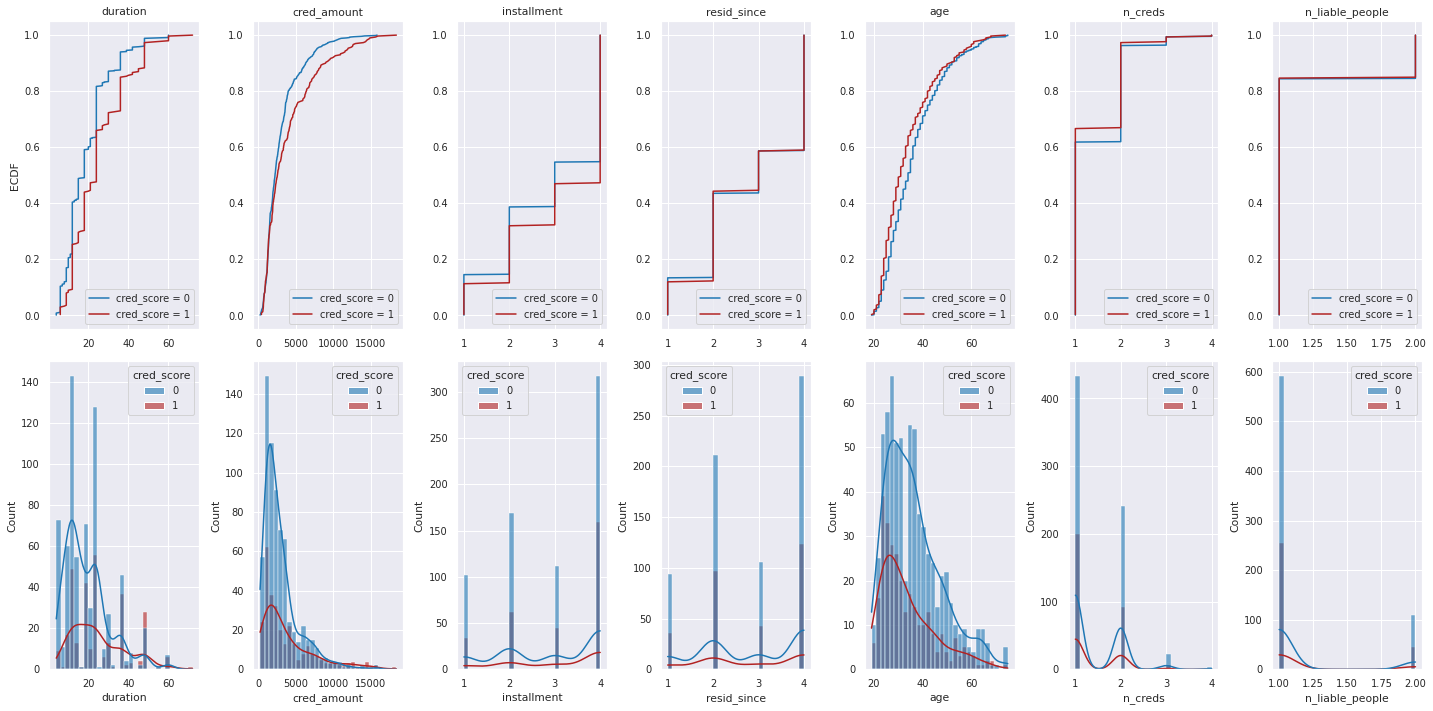

In [18]:
fig, ax = plt.subplots(2, 7, figsize=(20, 10))

for i in range(len(num_vars)):
    feature = num_vars[i]   # selecionando feature
    
    # plotando ECDF
    ecdf0 = ECDF(data[data['cred_score'] == 0][feature])  # score 1
    ecdf1 = ECDF(data[data['cred_score'] == 1][feature])  # score 2
    
    ax[0,i].plot(ecdf0.x, ecdf0.y, color=cores['bom'], label='cred_score = 0')
    ax[0,i].plot(ecdf1.x, ecdf1.y, color=cores['ruim'], label='cred_score = 1')    
    
    # plotando histogramas
    sns.histplot(x=feature, hue='cred_score', data=data, bins=30, alpha=0.6,
                 ax=ax[1,i], kde=True, palette=[cores['bom'], cores['ruim']])
    
    # ajustando labels
    ax[0,i].set_title(feature)
    ax[0,i].legend(loc='lower right')

ax[0,0].set_ylabel('ECDF')
plt.tight_layout()

Analisando as ECDFs (primeira linha), vemos que algumas suspeitas são confirmadas: 

1. Indivíduos de escore ruim (alto risco) tendem a captar crédito com maiores prazos e em maiores quantias monetárias.
2. Adicionalmente, clientes de alto risco tendem a ser ligeiramente mais novos. 
3. Ainda, a variável `installment` revela que clientes com escore ruim são aqueles cujas taxas de parcelamento representam uma maior proporção de sua renda disponível. 

<br>

No entanto, a distribuição individual das variáveis não nos diz muita coisa a respeito do problema em si. Afinal, estamos mais interessados na maneira pela qual estas estão associadas à variável resposta (escore de crédito). 

Assim, vamos investigar a correlação entre estas variáveis e as categóricas. Adicionalmente, investigaremos como todo o conjunto de features está associado ao escore de crédito. 

-----

**Raciocínio:** se separarmos nossa amostra em dois grupos (alto risco e baixo risco), a pergunta que queremos responder é _"O que diferencia o perfil de crédito entre esses dois grupos?, i.e., Qual comportamento observado no conjunto de features pode apontar um maior nível de risco?"_

-----

## Descrevendo features categóricas

Vamos começar analisando a relação entre idade, gênero, status_social, volume e escore de crédito. 

### Idade e volume de crédito vs gênero

**Perguntas:** 

- Será que características como idade, gênero e status social estão, de alguma forma, associadas à um maior/menor risco de crédito? 

- Como estas se associam com outras variáveis contínuas? Será que Homens/Mulheres pedem diferentes volumes de crédito? Será que sua idade ajuda a explicar seu escore de crédito?

-----

<font color='red'>**OBS:**</font> a duração do empréstimo (`duration`) e o volume monetário (`cred_amount`) tendem a ser positivamente correlacionados (de fato, na amostra observou-se que $\rho = 0.64984$, coef. de Pearson), i.e., quanto maior a quantia solicitada, maior o prazo para pagamento. Por esse motivo, vamos focar a análise a partir daqui no volume de crédito. 

In [19]:
# contando quantos clientes de cada gênero possuem um dado escore de crédito
count = data.groupby(['gender', 'cred_score']).count()['duration'].reset_index()
count.rename(columns={'duration':'count'}, inplace=True)
count.sort_values('gender', inplace=True, ascending=False)

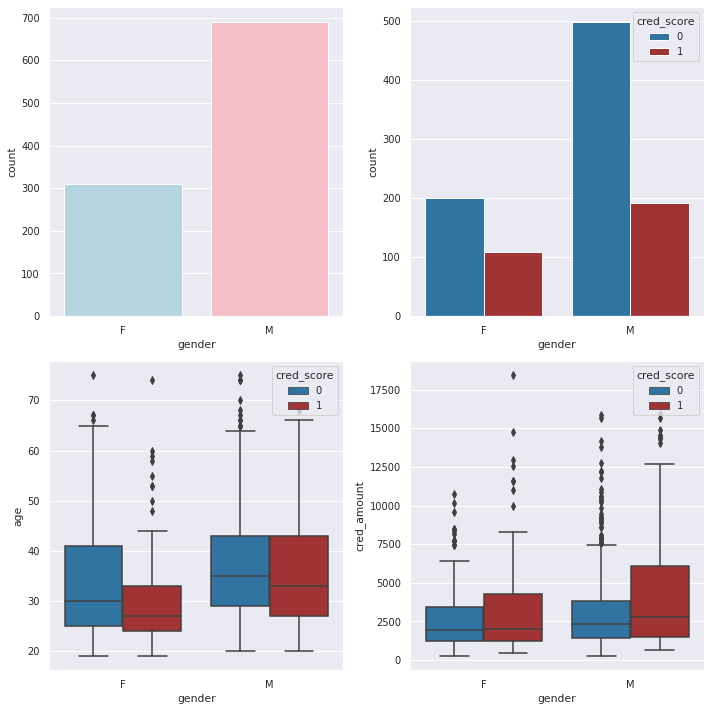

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sns.barplot(x='index', y='gender', data=data['gender'].value_counts().reset_index(), 
            ax=ax[0,0], palette=['lightblue', 'lightpink'])

sns.barplot(x='gender', y='count', hue='cred_score', data=count, 
            ax=ax[0,1], palette=[cores['bom'], cores['ruim']])

sns.boxplot(x='gender', y='age', hue='cred_score', data=data, 
            ax= ax[1,0], palette=[cores['bom'], cores['ruim']])

sns.boxplot(x='gender', y='cred_amount', hue='cred_score', data=data, 
            ax= ax[1,1], palette=[cores['bom'], cores['ruim']])

# ajustes 
ax[0,0].set_xlabel('gender')
ax[0,0].set_ylabel('count')
ax[0,1].legend(loc='upper right', title='cred_score')
ax[1,0].legend(loc='upper right', title='cred_score')
ax[1,1].legend(loc='upper right', title='cred_score')

plt.tight_layout()

É fácil ver que, em toda a amostra, há muito mais homens (690) que mulheres (310), 69% e 31% respectivamente. Ainda, nota-se que quase metade das mulheres têm alto risco de crédito.

Como podemos ver no boxplot acima (idade vs gênero), mulheres com score de crédito ruim tendem a ser mais jovens. Isso pode ser um indicativo de que clientes com esse perfil tenham probabilidade ligeiramente maior de não pagar devidamente o crédito tomado.

Por fim, para ambos os gêneros, indivíduos de alto risco tendem a tomar maior volume de crédito. Confirmando o que foi observado previamente.

### Idade e volume de crédito vs status social

De maneira semelhante à seção 1.4.1, podemos fazer o mesmo conjunto de perguntas quanto ao status social.

In [21]:
# contando quantos clientes de cada categoria de status social possuem um dado escore de crédito
count = data.groupby(['social_status', 'cred_score']).count()['duration'].reset_index()
count.rename(columns={'duration':'count'}, inplace=True)
count.sort_values('count', inplace=True, ascending=False)

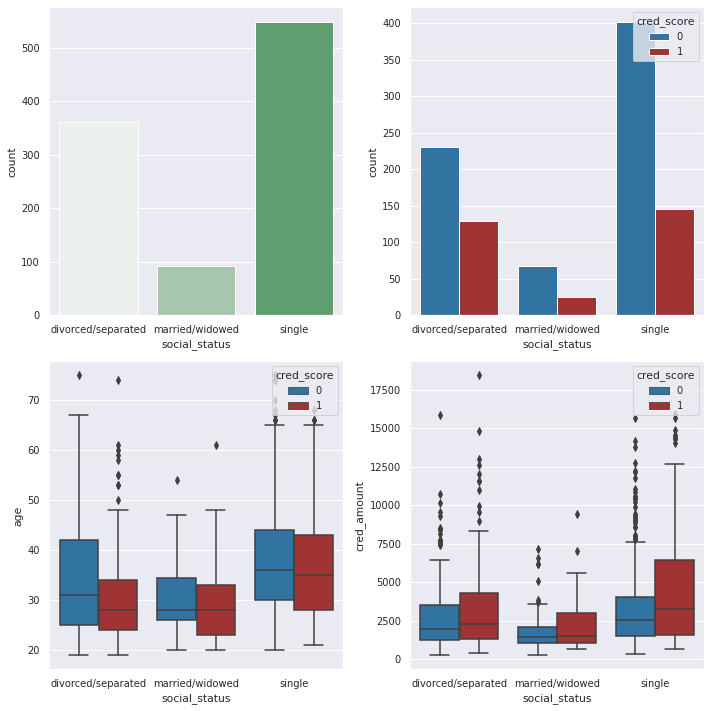

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sns.barplot(x='index', y='social_status', data=data['social_status'].value_counts().reset_index(), 
            ax=ax[0,0], palette='light:g')

sns.barplot(x='social_status', y='count', hue='cred_score', data=count, 
            ax=ax[0,1], palette=[cores['bom'], cores['ruim']])

sns.boxplot(x='social_status', y='age', hue='cred_score', data=data, 
            ax= ax[1,0], palette=[cores['bom'], cores['ruim']])

sns.boxplot(x='social_status', y='cred_amount', hue='cred_score', data=data, 
            ax= ax[1,1], palette=[cores['bom'], cores['ruim']])

# ajustes 
ax[0,0].set_xlabel('social_status')
ax[0,0].set_ylabel('count')
ax[0,1].legend(loc='upper right', title='cred_score')
ax[1,0].legend(loc='upper right', title='cred_score')
ax[1,1].legend(loc='upper right', title='cred_score')

plt.tight_layout()

Nos gráficos acima, vemos que a maior parte dos clientes presentes na amostra são solteiros ou divorciados. 

No que diz respeito aos indivíduos com maior risco de crédito, estes tendem a ser mais novos e solicitar uma quantia de crédito maior. Em especial, a proporção de clientes de alto risco é maior entre os divorciados.

Para termos mais insights nesse sentido, vamos combinar as informações de gênero e status social.

-----

### combinando gênero e status social

Vamos investigar possíveis diferenças entre homens solteiros e casados, além de distinções entre os gêneros.

In [24]:
temp = data.copy()  # criando cópia temporária do dataset

# criando coluna combinando as duas informações (dessa forma, consigo codificar no eixo X)
temp['gender_status'] = temp['gender'].astype(str) + ', ' + temp['social_status'].astype(str)
temp.sort_values('gender_status', inplace=True)

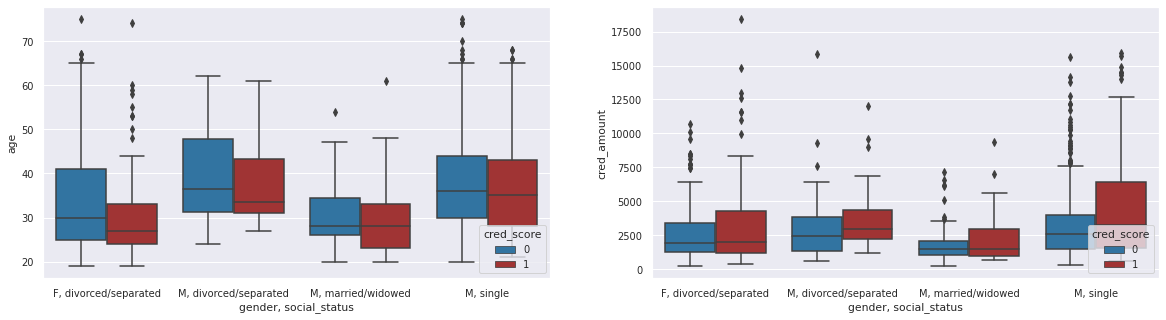

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.boxplot(x='gender_status', y='age', hue='cred_score', data=temp, 
            ax=ax[0], palette=[cores['bom'], cores['ruim']])

sns.boxplot(x='gender_status', y='cred_amount', hue='cred_score', data=temp, 
            ax=ax[1], palette=[cores['bom'], cores['ruim']])


#plt.xticks(rotation=45)
ax[0].set_xlabel('gender, social_status')
ax[1].set_xlabel('gender, social_status')
ax[0].legend(loc='lower right', title='cred_score')
ax[1].legend(loc='lower right', title='cred_score')

Como curiosidade, podemos apontar o fato de que todo o público feminino da amostra são divorciadas / separadas. 

Em linha com o que foi observado previamente, o público de alto risco engloba indivíduos mais jovens e que solicitam maior quantia de crédito.

Em especial para homens solteiros. 

In [26]:
# deletando base temporária (para que alterações não sejam permanentes e alterem a forma do dataset original)
del temp

### Histórico de crédito

Vamos agora investigar se clientes que são bons pagadores tendem, ou não, a ter bom escore de crédito. 

In [27]:
count = data.groupby(['cred_history', 'cred_score']).count()['duration'].reset_index()
count.sort_values(['duration','cred_score'], inplace=True, ascending=False)
count.rename(columns={'duration':'count'}, inplace=True)

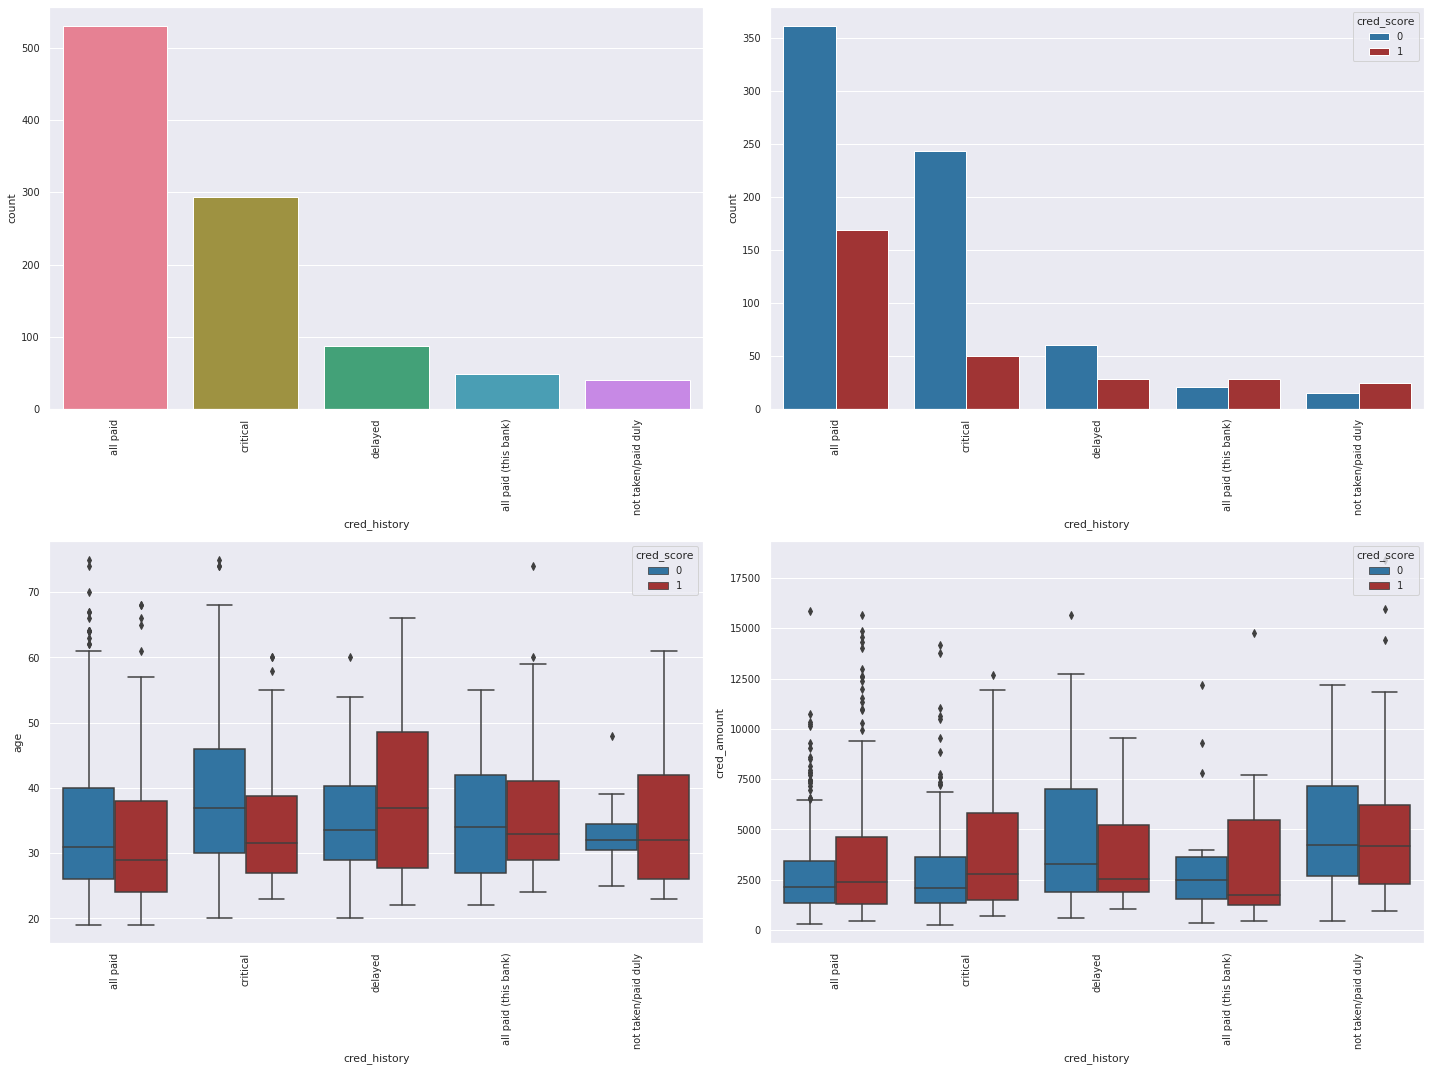

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.barplot(x='index', y='cred_history', data=data['cred_history'].value_counts().reset_index(), 
            ax=ax[0,0], palette='husl', order= count['cred_history'].unique())

sns.barplot(x='cred_history', y='count', hue='cred_score', data=count, 
            ax=ax[0,1], palette=[cores['bom'], cores['ruim']], order= count['cred_history'].unique())


sns.boxplot(x='cred_history', y='age', hue='cred_score', data=data, 
            ax= ax[1,0], palette=[cores['bom'], cores['ruim']], order= count['cred_history'].unique())

sns.boxplot(x='cred_history', y='cred_amount', hue='cred_score', data=data, 
            ax= ax[1,1], palette=[cores['bom'], cores['ruim']], order= count['cred_history'].unique())

# ajustes 
ax[0,0].set_xlabel('cred_history')
ax[0,0].set_ylabel('count')
ax[0,1].legend(loc='upper right', title='cred_score')
ax[1,0].legend(loc='upper right', title='cred_score')
ax[1,1].legend(loc='upper right', title='cred_score')

# rotationando labels do eixo x
for axes in ax:
    for a in axes:
        for label in a.get_xticklabels():
            label.set_rotation(90) 

plt.tight_layout()

Vemos que as duas classes dominantes são `all paid` e `critical`, i.e., a maior parte dos clientes pagaram seus empréstimos prévios em dia ou apresenta histórico ruim, podendo também ter outros empréstimos ativos em outras instituições bancárias. 

Curiosamente, indivíduos que pagaram devidamente empréstimos prévios no mesmo banco são, em maior quantidade, de alto risco. O mesmo vale para indivíduos sem histórico de crédito. 

<br>
<br>

Vamos agora avaliar o propósito pelo qual os indivíduos solicitam crédito e investigar se esse fator exerce alguma influência sobre o nível de risco do solicitante. 

-----
**Pergunta:** Será que indivíduos que solicitam empréstimo para combrar um bem móvel (ex. carro) representam risco mais elevado em comparação com aqueles que tomam crédito para comprar um bem imóvel (ex. casa, apto. etc)?

-----

### Propósito

Vamos analisar, em mais detalhes, os motivos pelos quais os indivíduos tomam crédito e como esses motivos estão relacionados ao volume de crédito e, em última instância, aos seus níveis de risco.

In [29]:
count = data.groupby(['purpose', 'cred_score']).count()['duration'].reset_index()
count.sort_values(['duration','cred_score'], inplace=True, ascending=False)
count.rename(columns={'duration':'count'}, inplace=True)

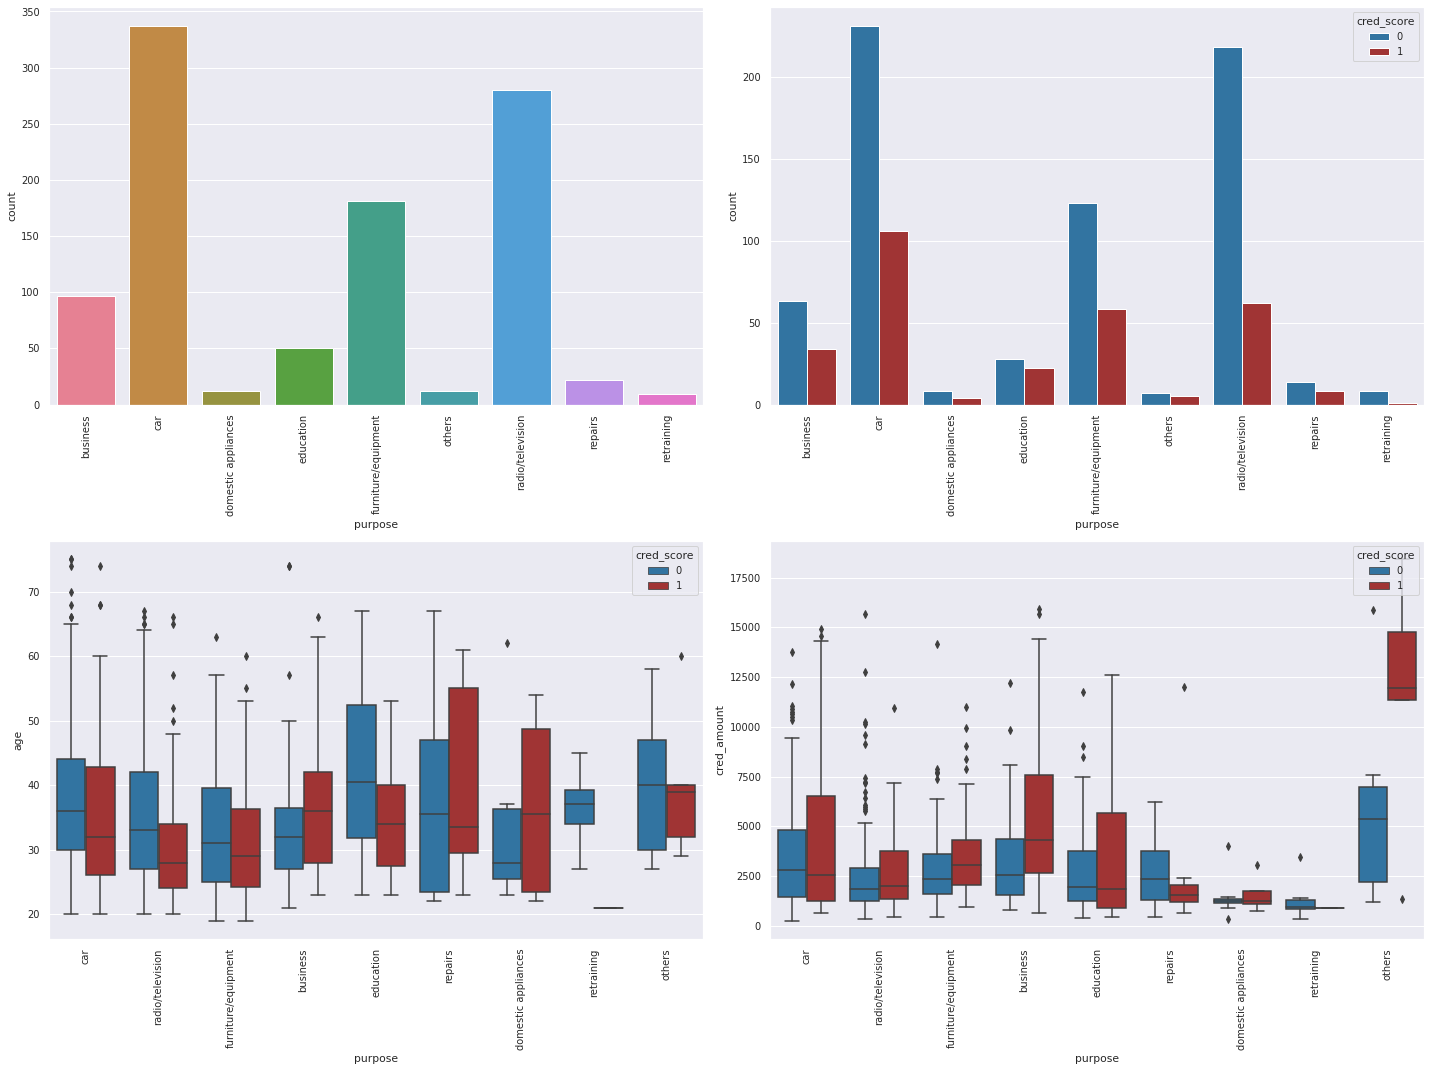

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.barplot(x='index', y='purpose', data=data['purpose'].value_counts().reset_index(), 
            ax=ax[0,0], palette='husl')

sns.barplot(x='purpose', y='count', hue='cred_score', data=count, 
            ax=ax[0,1], palette=[cores['bom'], cores['ruim']])


sns.boxplot(x='purpose', y='age', hue='cred_score', data=data, 
            ax= ax[1,0], palette=[cores['bom'], cores['ruim']], order= count['purpose'].unique())

sns.boxplot(x='purpose', y='cred_amount', hue='cred_score', data=data, 
            ax= ax[1,1], palette=[cores['bom'], cores['ruim']], order= count['purpose'].unique())

# ajustes 
ax[0,0].set_xlabel('purpose')
ax[0,0].set_ylabel('count')
ax[0,1].legend(loc='upper right', title='cred_score')
ax[1,0].legend(loc='upper right', title='cred_score')
ax[1,1].legend(loc='upper right', title='cred_score')

# rotationando labels do eixo x
for axes in ax:
    for a in axes:
        for label in a.get_xticklabels():
            label.set_rotation(90) 

plt.tight_layout()

Como podemos ver nos gráficos acima, a maioria dos indivíduos solicita empréstimo para comprar um carro (seja ele novo ou usado). 

Porém, em termos de proporção, os que tomam crédito para financiamento estudantil apresentam a maior parcela de clientes de alto risco (quase 50% dos indivíduos desta categoria).

Quanto à idade, podemos apontar tendências distintas para clientes de alto risco: 

- para o propósito de adquirir carro, televisão, móveis ou investir em educação, este grupo tende a ser constituído por indivíduos mais jovens. 
- já para os motivos de investir em negócios, reparos ou aplicações domésticas, o grupo de alto risco contém indivíduos mais jovens. 

Para a maioria destes propósitos, indivíduos de alto risco solicitam maiores quantias monetárias de empréstimo. 

-----

Como curiosidade, podemos apontar o fato de que a categoria `Outros` é facilmente separável no sentido de que indivíduos de alto risco tendem a solicitar volumes de crédito substancialmente maiores que indivíduos de baixo risco. No entanto, há poucos registros nessa categoria.

-----

### cross tabulation

Por fim, vamos analisar mais algumas variáveis categóricas que apresentam pouca variabilidade, mas que podem ajudar a responder importantes questões.

**OBS:** deve-se usar a tabulação cruzada com cautela devido ao desbalanceamento da amostra. Assim, serão feitas análises apenas considerando percentuais em relação ao número de observações de cada grupo (alto risco e baixo risco).

#### status_check_acc e savings

**Pergunta:** será que a quantia retida na conta corrente/poupança afeta, de alguma forma, o risco de crédito?

In [31]:
pd.crosstab(data['cred_score'], data['status_check_acc'], normalize='index')

status_check_acc,0 DM,<200 DM,>=200 DM,None
cred_score,,,,
0,0.198571,0.234286,0.070000,0.497143
1,0.450000,0.350000,0.046667,0.153333


Analisando a tabela acima, podemos destacar dois pontos: 

1. grande parte dos clientes de baixo risco não tem status reportado da sua conta corrente (49%)
2. uma parcela significativa dos clientes de alto risco não tem saldo em suas contas correntes (45%). Ainda, a maioria destes indivíduos tem saldo infetior a `200 DM` (aprox. 80%).

Fazendo a mesma análise para a poupança, vemos que...

In [32]:
pd.crosstab(data['cred_score'], data['savings'], normalize='index')

savings,<100 DM,<500 DM,<1000 DM,>= 1000 DM,None
cred_score,,,,,
0,0.551429,0.098571,0.074286,0.06,0.215714
1,0.723333,0.113333,0.036667,0.02,0.106667


1. A maioria dos clientes de baixo risco têm saldo inferior a `100 DM` ou não reportaram o status de suas contas poupança. 
2. A mesma observação vale para clientes de alto risco. 

Isto posto, podemos afirmar que a quantia retida em investimentos de baixo risco (poupança e títulos públicos) não é uma boa medida para diferenciar os dois grupos de clientes.

-----

#### housing e property

Agora, vamos investigar se o tipo de residência ou a propriedade (talvez dada commo garantia) ajuda a explicar o escore de crédito.

In [33]:
pd.crosstab(data['cred_score'], data['housing'], normalize='index')

housing,rent,own,free
cred_score,,,
0,0.155714,0.752857,0.091429
1,0.233333,0.620000,0.146667


In [34]:
pd.crosstab(data['cred_score'], data['property'], normalize='index')

property,real estate,savings/life insurance,car,unknown/none
cred_score,,,,
0,0.317143,0.230000,0.328571,0.124286
1,0.200000,0.236667,0.340000,0.223333


Vemos que, para essas variáveis (`housing` e `property`), não há diferenças significativas entre indivíduos de alto e baixo risco.

-----

Por fim, vamos olhar para o tipo de emprego e se o cliente é um trabalhador estrangeiro.

#### job e foreign

**Pergunta:** Será que o tipo de emprego reportado pelo cliente influencia seu risco de crédito? E o fato de ser trabalhador estrangeiro?

In [35]:
pd.crosstab(data['cred_score'], data['job'], normalize='index')

job,unemployed/unskilled,unskilled (resident),skilled,executive/highly skilled
cred_score,,,,
0,0.021429,0.205714,0.634286,0.138571
1,0.023333,0.186667,0.620000,0.170000


In [36]:
pd.crosstab(data['cred_score'], data['foreign'], normalize='index')

foreign,1,0
cred_score,,
0,0.952857,0.047143
1,0.986667,0.013333


Também não vemos diferenças significativas na distribuição destas variáveis entre os grupos de baixo e alto risco.

<br>

Com os insights identificados ao longo deste notebook em mente, passamos agora para análise preditiva.

-----

**Fim!**

Confira os demais notebooks para visualizar como as features foram tratadas e saber mais detalhes sobre a análise preditiva.